<a href="https://colab.research.google.com/github/Sadia-Khan-Rupa/cancer1/blob/main/Copy_of_squeezenet_working_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install SimpleITK

In [ ]:
%pip install scipy==1.1.0

https://github.com/tensorflow/tensorflow/issues/28287

In [ ]:
%pip install tflearn

In [ ]:
%pip install Pillow

In [ ]:
 %pip install tensorflow==1.15.5

In [ ]:
%pip install keras==1.0.8

In [ ]:
%pip install utils

In [ ]:
from PIL import Image
from sklearn.utils import class_weight
from scipy.misc import imread
from joblib import Parallel, delayed
import tflearn as tf
from tflearn.data_utils import build_hdf5_image_dataset
from scipy.ndimage import rotate, imread
import h5py
import numpy as np 
import pandas as pd
import os
%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None
from keras.layers import Input, merge
from tensorflow.keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from tensorflow.keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam ,SGD,RMSprop
from tensorflow.keras.utils import  to_categorical
import tensorflow as tf


import numpy as np
# import matplotlib.pyplot as plt
# print(matplotlib.__file__)
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import *

Instructions for updating:
non-resource variables are not supported in the long term



Using TensorFlow backend.


In [ ]:
os.chdir('/content/drive/MyDrive/train_again/')
!ls

eval_data	   image_2139049.jpg  image_362920.jpg
eval_labels	   image_2139078.jpg  image_362938.jpg
image_1000013.jpg  image_2139171.jpg  image_362974.jpg
image_1000078.jpg  image_2139444.jpg  image_363001.jpg
image_100035.jpg   image_2139484.jpg  image_363235.jpg
image_10004.jpg    image_2139508.jpg  image_363388.jpg
image_100176.jpg   image_214137.jpg   image_36356.jpg
image_100231.jpg   image_214142.jpg   image_363623.jpg
image_100235.jpg   image_2141871.jpg  image_364178.jpg
image_1003080.jpg  image_2142156.jpg  image_364207.jpg
image_1003223.jpg  image_2142381.jpg  image_364403.jpg
image_1003285.jpg  image_2142730.jpg  image_364540.jpg
image_1003289.jpg  image_2144274.jpg  image_364603.jpg
image_1003303.jpg  image_214556.jpg   image_364773.jpg
image_1003401.jpg  image_214603.jpg   image_364793.jpg
image_1003406.jpg  image_2146708.jpg  image_364832.jpg
image_1003461.jpg  image_2146807.jpg  image_365026.jpg
image_100365.jpg   image_2146860.jpg  image_365540.jpg
image_100406.jpg   im

In [ ]:
# Load HDF5 dataset
def load_hdf_dataset(mode):
    h5_file = h5py.File(mode+ 'dataset.h5', 'r')
    images = h5_file ['X']
    labels = h5_file ['Y'][:]
    
    images = images[:,:,:].reshape([-1,50,50,1])
    h5_file.close()
    return images, labels 




train_images , tr_labels = load_hdf_dataset('train_again')

    

val_images , val_labels = load_hdf_dataset('val_again')

# images = np.concatenate((train_images,val_images))

# labels  = np.concatenate((tr_labels,val_labels))

# getting indexes
lab_0 = tr_labels[:,0] 
zeros_class= np.where(lab_0 ==1)
lab_1 = tr_labels[:,1]
ones_class= np.where(lab_1 ==1)

for no in zeros_class:
    train_0 = train_images[no,:,:,:]
    train_labels_0 = tr_labels[no,:]

for no in ones_class:
    
    train_1 = train_images[no,:,:,:]
    train_labels_1 = tr_labels[no,:]


train_0 = train_0[ :len(train_labels_1), :,:,:]
train_labels_0= train_labels_0[ :len(train_labels_1), :]

images = np.concatenate((train_0,train_1))
images = np.asarray(images)

labels =  np.concatenate((train_labels_0,train_labels_1))
labels = np.asarray(labels)
labels.shape


(5196, 2)

In [ ]:


y_score = []
def build_squeezenet(input_shape):
    
    input_layer = Input(shape = input_shape)
    
    out = Conv2D(96, kernel_size =(3, 3), activation='relu')(input_layer)
    out = MaxPooling2D(pool_size=2, strides=None, padding='valid')(out)
    # no mxpooling done since small images 
    out = fire_module(out,squeeze =16 , expansion =64)
    out = fire_module(out,squeeze = 16 , expansion=64)
    
    out = fire_module(out,squeeze= 32,expansion = 128)
    out = fire_module(out,squeeze= 32,expansion = 128)
    
    out = fire_module(out , squeeze = 48 ,expansion=192)
    out = fire_module(out,squeeze = 48 , expansion = 192)
    
    out = fire_module(out,squeeze = 64 , expansion = 256)
    out = fire_module(out,squeeze = 64 , expansion = 256)
    
    out = Dropout(0.5)(out)
    out = Conv2D(32,kernel_size=(1,1),padding='valid',activation='relu')(out)
    out = GlobalAveragePooling2D()(out)
    out = Dense(2, activation="softmax")(out)
    y_score =out[:,]
      
    model = Model(input_layer, out, name='squeezenet')
    return model  


In [ ]:
def fire_module(input_layer, squeeze =16 , expansion =32):

# a definition for fire module et.al https://github.com/rcmalli/keras-squeezenet/
# inspiration out = tf.map_fn(lambda x: threshold_binarize(x, threshold=0.5) , out, dtype=tf.int64)
# squeezing using 1x1 kernel and expansion with 1x1 and 3x3. Concatenate the output to get best result.

    fire_sq = Conv2D(squeeze,1,1,activation= 'relu')(input_layer)
    fire_exp1 = Conv2D(expansion ,kernel_size=(1,1),activation='relu',padding='valid')(fire_sq)
    fire_exp2 = Conv2D(expansion ,kernel_size=(3,3),activation='relu',padding='same')(fire_sq)
    out = concatenate([fire_exp1,fire_exp2], axis=3)

    return out

In [ ]:

model_dw = build_squeezenet(input_shape= (50,50,1))





adam = Adam(learning_rate=0.0001)
model_dw.compile(
    optimizer=adam, loss='categorical_crossentropy',
    metrics=['accuracy'])

# weights = class_weight.compute_class_weight('balanced',
#                                             np.unique(val_labels[:,0]) ,
#                                             val_labels[:,0])
wt = np.array([ 0.4,0.6])
# model_dw.summary()
model_dw.fit(x=train_images, 
            y=tr_labels, 
            batch_size=32,
            epochs=10, 
            verbose=1,  
#             validation_split=0.2,
            class_weight= wt,
            validation_data=(val_images,val_labels), 
            shuffle=True)

# pred = model_dw.predict(val_image

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 6055 samples, validate on 1501 samples
Epoch 1/10
6055/6055 [==============================] - 448s 74ms/sample - loss: 0.6858 - acc: 0.5696 - val_loss: 0.6832 - val_acc: 0.5803
Epoch 2/10
6055/6055 [==============================] - 443s 73ms/sample - loss: 0.6841 - acc: 0.5709 - val_loss: 0.6802 - val_acc: 0.5803
Epoch 3/10
6055/6055 [==============================] - 446s 74ms/sample - loss: 0.6824 - acc: 0.5709 - val_loss: 0.6770 - val_acc: 0.5776
Epoch 4/10
6055/6055 [==============================] - 444s 73ms/sample - loss: 0.6754 - acc: 0.5577 - val_loss: 0.6737 - val_acc: 0.5476
Epoch 5/10
6055/6055 [==============================] - 444s 73ms/sample - loss: 0.6621 - acc: 0.5680 - val_loss: 0.6276 - val_acc: 0.6029
Epoch 6/10
6055/6055 [==============================] - 448s 74ms/sample - loss: 0.6237 - acc: 0.6238 - val_loss: 0.5752 - val_acc: 0.6716
Epoch 7/10
6055/6055 [===============

https://keras.io/guides/training_with_built_in_methods/
https://stackoverflow.com/questions/51344839/what-is-the-difference-between-the-terms-accuracy-and-validation-accuracy

https://stackoverflow.com/questions/51335133/keras-how-come-accuracy-is-higher-than-val-acc

In [ ]:
pred = model_dw.predict(val_images)


In [ ]:
y_score = pred[:,1]
y_sq = pd.DataFrame(y_score)
y_sq.to_csv('texts.csv')

In [ ]:
y_true=val_labels[:,1]
prediction= pd.DataFrame(y_true)
prediction.to_csv('predictions.csv')

0.829755981994788


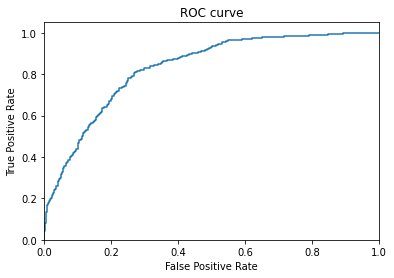

In [ ]:
from sklearn.metrics import roc_curve , confusion_matrix, classification_report

fpr , tpr, thres = roc_curve(y_true , y_score , pos_label = 1) 


y= []

for i in range(len(y_score)):
    if (y_score[i]>=0.5):
        y.append(1)
    else :
        y.append(0)

y = np.asarray(y)
tn , fp , fn , tp = confusion_matrix(y_true, y).ravel()

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc , roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_true, y_score))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/


<function matplotlib.pyplot.show>

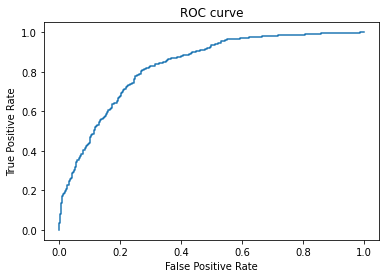

In [ ]:
plt.figure()
plt.plot(fpr[0],tpr[0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show

Train on 6055 samples, validate on 1501 samples
Epoch 1/10
6055/6055 [==============================] - 444s 73ms/sample - loss: 0.4645 - acc: 0.7761 - val_loss: 0.5259 - val_acc: 0.7202
Epoch 2/10
6055/6055 [==============================] - 441s 73ms/sample - loss: 0.4583 - acc: 0.7827 - val_loss: 0.4679 - val_acc: 0.7728
Epoch 3/10
6055/6055 [==============================] - 441s 73ms/sample - loss: 0.4313 - acc: 0.7936 - val_loss: 0.4362 - val_acc: 0.7968
Epoch 4/10
6055/6055 [==============================] - 441s 73ms/sample - loss: 0.4124 - acc: 0.8013 - val_loss: 0.4232 - val_acc: 0.8028
Epoch 5/10
6055/6055 [==============================] - 441s 73ms/sample - loss: 0.3898 - acc: 0.8182 - val_loss: 0.4062 - val_acc: 0.8161
Epoch 6/10
6055/6055 [==============================] - 441s 73ms/sample - loss: 0.3777 - acc: 0.8236 - val_loss: 0.4451 - val_acc: 0.8028
Epoch 7/10
6055/6055 [==============================] - 442s 73ms/sample - loss: 0.3738 - acc: 0.8261 - val_loss: 0.40

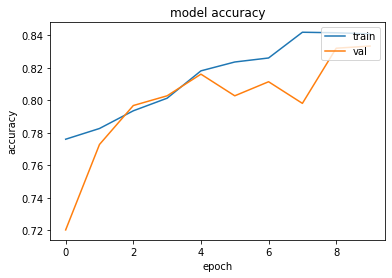

In [ ]:
import keras
from matplotlib import pyplot as plt
history = model_dw.fit(x=train_images, 
            y=tr_labels, 
            batch_size=32,
            epochs=10, 
            verbose=1,  
#             validation_split=0.2,
            class_weight= wt,
            validation_data=(val_images,val_labels), 
            shuffle=True)
history.to_csv('accuracy.csv')
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy